In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

<font  style="font-size: 4rem; color: #1abc9c"> SVM </font>

# <font color="#1E90FF">Exercise 1. Linear SVM - Influence of hyper-parameter C</font>

## <font color="#9400D3">1. Load, analyze and visualize data</font>

Warning: in this particular exercise, we will not split the dataset in train/val/test.

In [2]:
dataset = pd.read_csv('./LineaireNoisy.txt', delimiter='\t')
dataset

,x1,x2,y
0,9.50,10.00,0
1,14.25,16.55,1
2,10.00,5.00,1
3,2.30,5.25,0
4,3.40,3.88,0
...,...,...,...
147,15.01,15.67,1
148,16.05,14.70,1
149,15.65,18.23,1
150,18.85,17.43,1


<font color="red">**Question 1:**</font> 
- How many examples $\boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)},...\boldsymbol{x}^{(n)}$ in the dataset?
- How many features $x_1, x_2,...x_d$ ? What are their types? Their distribution?
- What are the classes?
- What is the class distribution over the dataset?

In [3]:
print("number of examples: ", dataset.shape[0])
print("number of features: ", dataset.shape[1])
print("Classes: ", dataset['y'].unique())
print("Distribution of classes :") 
print(dataset['y'].value_counts())

number of examples:  152
number of features:  3
Classes:  [0 1]
Distribution of classes :
0    76
1    76
Name: y, dtype: int64


### Plotting the dataset

<AxesSubplot:xlabel='x1', ylabel='x2'>

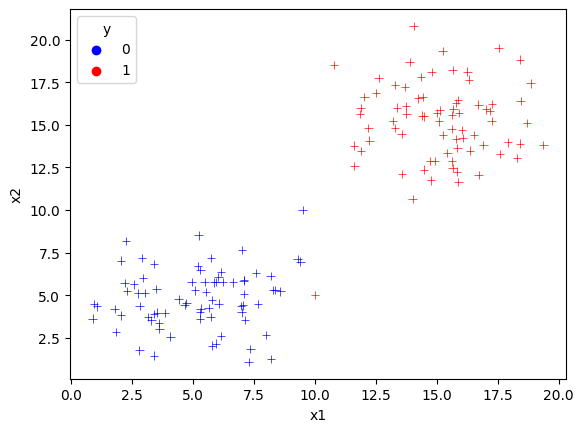

In [4]:
sns.scatterplot(data=dataset, x='x1', y='x2', hue='y', marker='+', palette=['blue','red'])

<font color="red">**Question 2:**</font>  Is this dataset linearly separable ? Find some examples that are close to the boundary

Sur le graphe ci-dessous, les points bleus et les points rouges sont clairement séparables avec une droite. 
Il y a juste un point rouge qui potentiellement pourrait être mal classé.

![q2](./exo1.png)

## <font color="#9400D3">2. Fitting a linear SVM to this dataset</font>

One implementation of SVM is done by class <code>SVC</code>, which stands for Support Vector Classification.
Documentation is available: 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [5]:
# SVC with linear kernel, and parameter C set to 1000
model_svm = svm.SVC(C = 1000, kernel = 'linear')

# Fit the model using the features (x1 and x2) and the target (y)
model_svm.fit(dataset.iloc[:,0:2], dataset.y)

SVC(C=1000, kernel='linear')

### Visualizing the SVM model

Run the following cells to see a plot of your dataset together with the decision boundary and the margins.

In [6]:
def svm_draw(model_svm, xmin, xmax, the_dataset):
    
    color_map = matplotlib.colors.ListedColormap(pd.Series(['blue', 'red']))


    plt.figure(figsize=(10, 8))
    # Plotting our two-features-space
    plt.scatter(the_dataset.iloc[:,0], the_dataset.iloc[:,1], c = the_dataset.y, cmap = color_map, marker='+')
    # Constructing a hyperplane using a formula.
    w = model_svm.coef_[0]           # w consists of 2 elements
    b = model_svm.intercept_[0]      # b consists of 1 element
    x_points = np.linspace(xmin, xmax)    # generating x-points from -1 to 1
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points

    plt.plot(x_points, y_points, c='g');

    plt.scatter(model_svm.support_vectors_[:, 0],
                model_svm.support_vectors_[:, 1], 
                s=50, 
                facecolors='none', 
                edgecolors='k', 
                alpha=1);

    # Step 2 (unit-vector):
    w_hat = model_svm.coef_[0] / (np.sqrt(np.sum(model_svm.coef_[0] ** 2)))
    # Step 3 (margin):
    margin = 1 / np.sqrt(np.sum(model_svm.coef_[0] ** 2))
    # Step 4 (calculate points of the margin lines):
    decision_boundary_points = np.array(list(zip(x_points, y_points)))
    points_of_line_above = decision_boundary_points + w_hat * margin
    points_of_line_below = decision_boundary_points - w_hat * margin
    # Plot margin lines
    # Blue margin line above
    plt.plot(points_of_line_above[:, 0], 
             points_of_line_above[:, 1], 
             'g--', 
             linewidth=2)
    # Green margin line below
    plt.plot(points_of_line_below[:, 0], 
             points_of_line_below[:, 1], 
             'g--',
             linewidth=2)

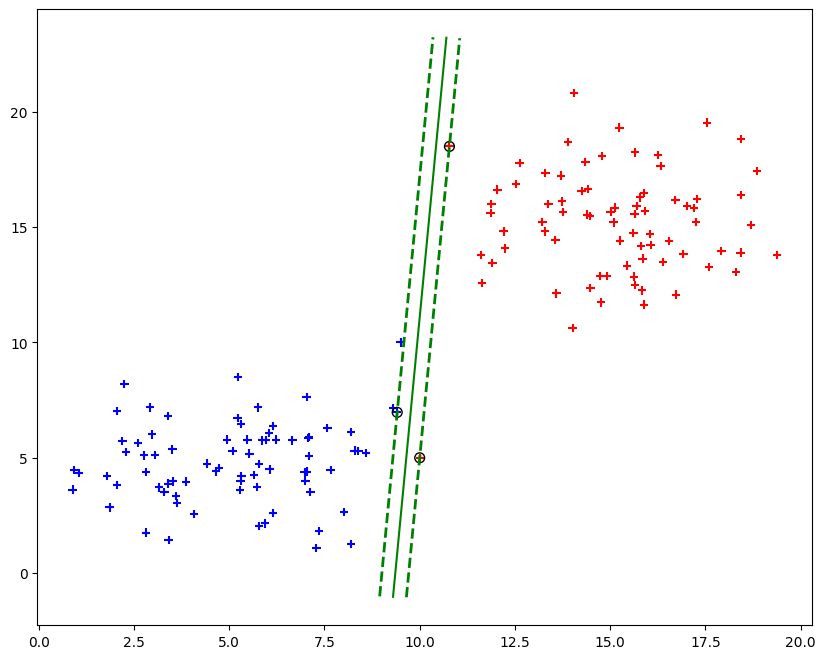

In [7]:
svm_draw(model_svm, 9.3, 10.7, dataset)

<font color="red">**Question 3:**</font>  
- What do you think of this boundary and these margins?
- How many points are inside the margins?
- How many points are misclassified by this model?

In this particular case the separator line allows to directly separate the data of our dataset:
- The line separates well the two classes (there are 0 misclassified points),
- The margins are equidistant from the closest points of different classes,
- But the points are too close to the margin to consider the model as optimal.

Indeed, in the general case, this line may not correspond to the best possible separation because points may appear around the margin which is not wide enough to give us enough "play". 

This model is **overfitting** and **cannot generalize new data**. So we will see how to find the best separation line.


- overfitting: the model is too complex and does not generalize well to new data
- inside margin : 3 points
- misclassified : 0 points

### SVM model analysis

We can also retrieve more precise information about the model that will allow us to understand its decision process.

Course reminder: when fitting a SVM model, a Lagrange coefficient is associated to each sample. In addition, one more parameter is also estimated: the constant of the model.

We can find these informations by the following commands:

In [8]:
# the support vectors found by the SVC
model_svm.support_vectors_

array([[ 9.41,  6.97],
       [10.  ,  5.  ],
       [10.78, 18.49]])

In [9]:
# the index of the support vectors in the dataset
model_svm.support_

array([ 62,   2, 102])

In [10]:
# the lagrange coefficients associated to the support vectors (alpha_i) multiplied by their targets (y_i)
model_svm.dual_coef_

array([[-4.04838982,  3.46935572,  0.5790341 ]])

In [11]:
# the constant of the model (w0)
model_svm.intercept_

array([-26.58177221])

<font color="red">**Question 4:**</font>  
- How many support vectors?
- What are the classes $y_i$ associated to each support vector?
- What are lagrange coefficients $\alpha_i$ associated to each support vector?

Be carefull: 'dual_coef_' returns the lagrange coefficients associated to the support vectors **multiplied by their targets** 

In [12]:
print("Support Vectors : ")
indexes = model_svm.support_
print(dataset.iloc[indexes, 0:2], end="\n\n")

print("Number of support vectors: ", model_svm.support_vectors_.shape[0])
classes_support_vectors = dataset.iloc[model_svm.support_, 2]
print(end="\n")

print("Classes y_i associated to the support vectors: ")
print(classes_support_vectors, end="\n\n")

print("Lagrange coefficients alpha_i associated to the support vectors: ")
lagrange_coefficients = model_svm.dual_coef_[0]
for i in range(model_svm.support_vectors_.shape[0]):
    print("alpha_{} = {}".format(i, lagrange_coefficients[i]), end="\n")

print("w0 = ", model_svm.intercept_[0])

Support Vectors : 
        x1     x2
62    9.41   6.97
2    10.00   5.00
102  10.78  18.49

Number of support vectors:  3

Classes y_i associated to the support vectors: 
62     0
2      1
102    1
Name: y, dtype: int64

Lagrange coefficients alpha_i associated to the support vectors: 
alpha_0 = -4.048389823022215
alpha_1 = 3.469355722298181
alpha_2 = 0.5790341007240324
w0 =  -26.581772205040433


There are 3 support vectors : 

| x1 | x2 | Class (y) | Lagrande coef |
| --- | --- | --- | --- |
| 9.41  | 6.97 | 0 |  -4.04838982  |
| 10.00  | 5.00 | 1 |  3.46935572  |
| 10.78 | 18.49 | 1 |  0.5790341  |



<font color="red">**Question 5:**</font> 
Deduce the equation $h_w(x)$ of this model. 

Formule de $h_w(x)$ :

$$
h_w(x)= \sum_{i=1}^{m} \alpha_i^* y^{(i)} (x \bullet x^{(i)}) + w_0^*
$$

$$
h_w(x)=-4.04838982*(-1)*(9.41*6.97)+3.46935572*1*(10.00*5.00)+0.5790341*1*(10.78*18.49)+-26.581772205040433
$$

### Classification with SVM model

<font color="blue">**todo:**</font> Apply the previous formula to compute the decisions $\hat{y}$ for the 2 first examples of the dataset. 

Hints: dot product between 2 vectors $x_1$ and $x_2$ is done by <code>np.dot(x_1, x_2)</code>.

<font color="red">**Question 6:**</font> 
- What represents the value $h_w(x)$?
- Are these examples correctly classified?

> Q6.1 : $h_w(x)$ represents the estimated value of the target $y$ for the example $x$.

In [13]:
# first and second point in the dataset
point1 = dataset.iloc[0, 0:2]
point2 = dataset.iloc[1, 0:2]
y1 = dataset.iloc[0, 2]
y2 = dataset.iloc[1, 2]
print("point1: \n", point1, "y1: ", y1)
print("point2: \n", point2, "y2: ", y2)

def h(x):
    # return model_svm.coef_[0][0] * x1 + model_svm.coef_[0][1] * x2 + model_svm.intercept_[0]
    return -4.04838982*(-1)*(np.dot(x[0], x[1]))+3.46935572*(np.dot(x[0], x[1])) + 0.5790341*(np.dot(x[0], x[1])) - 26.581772205040433


print(h(point1))
print(h(point2))

point1: 
 x1     9.5
x2    10.0
Name: 0, dtype: float64 y1:  0
point2: 
 x1    14.25
x2    16.55
Name: 1, dtype: float64 y2:  1
742.6122935949594
1882.9424961434595


You can obtain the $h_w(x)$ values for the examples in the dataset using the function 
<code>decision_function</code>.

Check your results.

In [14]:
print('\n',dataset.iloc[:2,:])
decision_values = model_svm.decision_function(dataset.iloc[:2,0:2])
print()
for i in range(len(decision_values)):
    print("decision value for sample {}: {}".format(i, decision_values[i]), end="\n")


       x1     x2  y
0   9.50  10.00  0
1  14.25  16.55  1

decision value for sample 0: -1.2414838865017792
decision value for sample 1: 11.174215477258404


> Q6.2 : For the 2 first samples, the model correctly classifies them.
>
> - for the first value, the expected value is 0 and the model outputs -1.241 (which is negative : which corresponds to the class 0)
> - for the second value, the expected value is 1 and the model outputs 11.17 (which is positive : which corresponds to the class 1)

<font color="red">**Question 6:**</font> what are the decision values for the support vectors? Which values are expected for support vectors? 

> Q6.3 : The decision values for the support vectors is the value of $h_w(x)$ for the support vectors.
> 
> The expected value for the support vectors is -1 or 1 because they are the closest points to the margin with a distance of 1.

In [15]:
# print the decision values for the support vectors
print("Support Vectors : ")
indexes = model_svm.support_
print(dataset.iloc[indexes, 0:3], end="\n\n")

# Calculate the decision values for the support vectors
print("Decision values for the support vectors: ")
decision_values = model_svm.decision_function(dataset.iloc[indexes, 0:2])
for i in range(model_svm.support_vectors_.shape[0]):
    print("decision value for support vector {}: {}".format(i, decision_values[i]), end="\n")
    


Support Vectors : 
        x1     x2  y
62    9.41   6.97  0
2    10.00   5.00  1
102  10.78  18.49  1

Decision values for the support vectors: 
decision value for support vector 0: -0.9997030442378865
decision value for support vector 1: 0.9994040735050653
decision value for support vector 2: 1.0002669063475516


> As expected they are the closest points to the margin with a distance of 1. and the classes are correctly classified.

## <font color="#9400D3">3. Change the hyperparameter C</font>

Even if the dataset is linearly separable, the previous boundary is not very adapted. Because C is very high the model favours no training error. 

<font color="blue">**Todo:**</font> 
- Fit a model with a smaller value of C: C = 1
- Plot the new boundary and margins

<font color="red">**Question 7:**</font> 
 - 1. How many support vectors are selected ?
 - 2. How many points are inside the margins ? on the margins ?
 - 3. How many points from the dataset are misclassified ?
 - 4. What are the lagrange values of $\alpha$ for the support vectors ?
 - 5. What are the values of $h_w(x)$ for the support vectors ?

In [16]:
# Fit a SVM model with C=1 
model_svm_C_lower = svm.SVC(C = 1, kernel = 'linear')

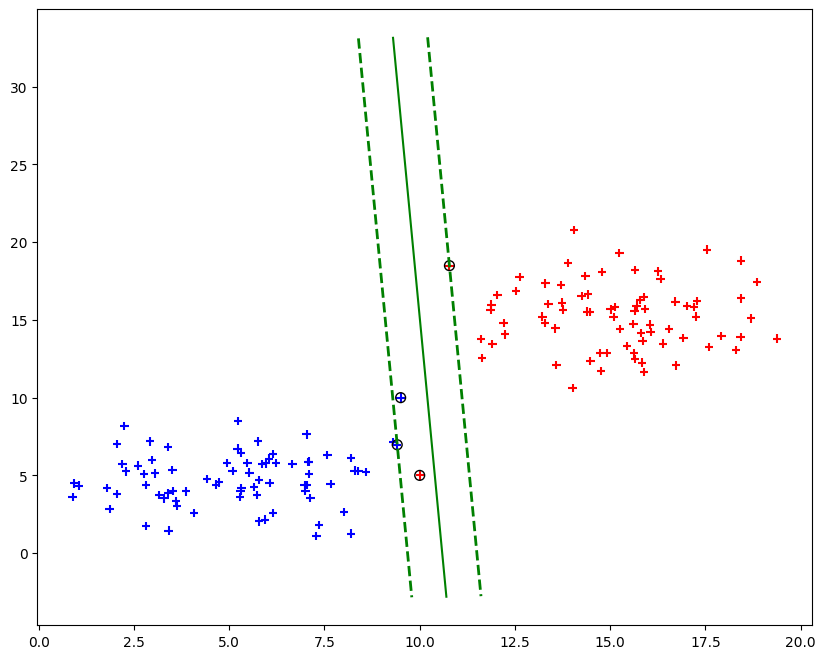

In [17]:
# Visualize boundary and margins
model_svm_C_lower.fit(dataset.iloc[:,0:2], dataset.y)
svm_draw(model_svm_C_lower, 9.3, 10.7, dataset)

In [18]:
# Support vectors with C=1
print("Support Vectors :")
indexes = model_svm_C_lower.support_

# Lagrande estimation with C=1
print(dataset.iloc[indexes,:])
print()


print("Lagrange coefficients alpha_i associated to the support vectors: ")
lagrange_coefficients = model_svm_C_lower.dual_coef_[0]
for i in range(model_svm_C_lower.support_vectors_.shape[0]):
    print("alpha_{} = {}".format(i, lagrange_coefficients[i]), end="\n")
print("w0 = ", model_svm_C_lower.intercept_[0])

print("\nSupport Vectors decision values: ")
decision_values = model_svm_C_lower.decision_function(dataset.iloc[indexes,0:2])
for i in range(len(decision_values)):
    print("decision value for sample {}: {}".format(i, decision_values[i]), end="\n")

Support Vectors :
        x1     x2  y
0     9.50  10.00  0
62    9.41   6.97  0
2    10.00   5.00  1
102  10.78  18.49  1

Lagrange coefficients alpha_i associated to the support vectors: 
alpha_0 = -1.0
alpha_1 = -0.4377455269394006
alpha_2 = 1.0
alpha_3 = 0.4377455269394007
w0 =  -11.6467925059905

Support Vectors decision values: 
decision value for sample 0: -0.7712497694552347
decision value for sample 1: -0.9999940580628213
decision value for sample 2: -0.43553643521121543
decision value for sample 3: 0.9999944997884462


<font color="red">**Question 7:**</font> 
- 1. How many support vectors are selected ?

> There are 4 support vectors

- 2. How many points are inside the margins ? on the margins ?

> This corresponds to the number of support vectors. There are 4 points inside the margins.

- 3. How many points from the dataset are misclassified ?

> It has only one point which is misclacified.

- 4. What are the lagrange values of $\alpha$ for the support vectors ?

> Lagrange coefficients alpha_i associated to the support vectors: 
> 
> - $alpha_0 = -1.0$
> - $alpha_1 = -0.4377455269394006$
> - $alpha_2 = 1.0$
> - $alpha_3 = 0.4377455269394007$
> - $w_0 =  -11.6467925059905$

- 5. What are the values of $h_w(x)$ for the support vectors ?

> | x1 | x2 | Class (y) | $$h_w(x)$$ |
> | --- | --- | --- | --- |
> | 9.50 | 10.00 | 0 | -0.7712497694552347 |
> | 9.41 | 6.97 | 0 | -0.9999940580628213 |
> | 10.00 | 5.00 | 1 | -0.43553643521121543 |
> | 10.78 | 18.49 | 1 | 0.9999944997884462 |




<font color="red">**Question 8:**</font>  Same as question 7 for C = 0.01.

hint: you'll have to modify xmin and xmax in the <code>svm_draw</code> function to 3 and 17

Support Vectors :
        x1     x2  y
0     9.50  10.00  0
11    5.24   8.50  0
25    8.19   6.13  0
39    9.30   7.14  0
62    9.41   6.97  0
64    7.03   7.64  0
2    10.00   5.00  1
87   11.61  13.78  1
93   14.01  10.63  1
106  11.91  13.44  1
120  11.63  12.56  1
129  13.59  12.12  1

Lagrange coefficients alpha_i associated to the support vectors: 
alpha_0 = -0.01
alpha_1 = -0.000627323999513436
alpha_2 = -0.01
alpha_3 = -0.01
alpha_4 = -0.01
alpha_5 = -0.01
alpha_6 = 0.01
alpha_7 = 0.01
alpha_8 = 0.01
alpha_9 = 0.01
alpha_10 = 0.01
alpha_11 = 0.000627323999513436
w0 =  -3.361052827175263

Support Vectors decision values: 
decision value for sample 0: -0.04123122213147257
decision value for sample 1: -1.000000133435524
decision value for sample 2: -0.9413556385389343
decision value for sample 3: -0.5815916640424237
decision value for sample 4: -0.5938995221381709
decision value for sample 5: -0.8617678203520809
decision value for sample 6: -0.8478167088246971
decision value for 

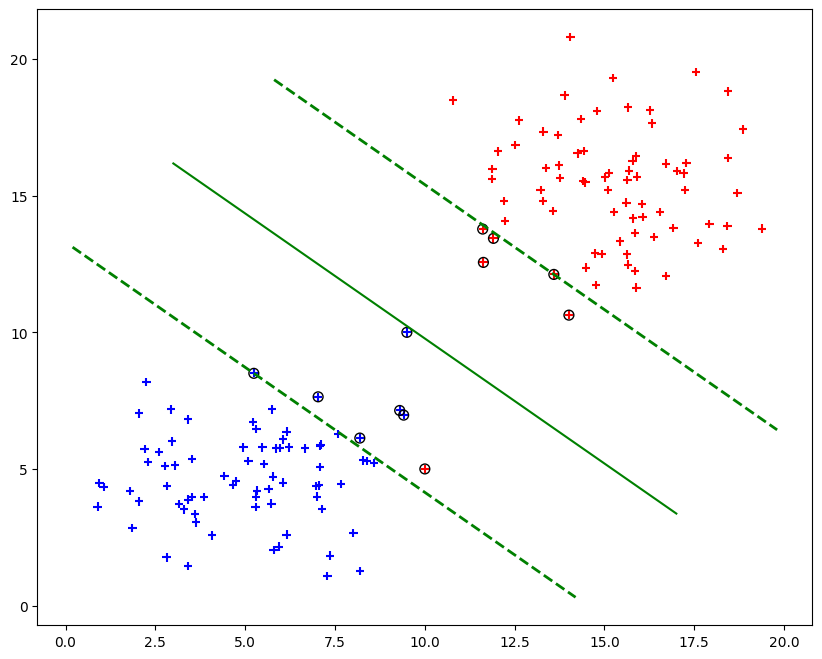

In [19]:
# TODO - Fit a SVM with C=0.01
model_svm_C_very_lower = svm.SVC(C = 0.01, kernel = 'linear')
# Visualize boundary and margins
model_svm_C_very_lower.fit(dataset.iloc[:,0:2], dataset.y)
svm_draw(model_svm_C_very_lower, 3, 17, dataset)

# Support vectors with C=1
print("Support Vectors :")
indexes = model_svm_C_very_lower.support_

# Lagrande estimation with C=1
print(dataset.iloc[indexes,:])
print()

print("Lagrange coefficients alpha_i associated to the support vectors: ")
lagrange_coefficients = model_svm_C_very_lower.dual_coef_[0]
for i in range(model_svm_C_very_lower.support_vectors_.shape[0]):
    print("alpha_{} = {}".format(i, lagrange_coefficients[i]), end="\n")
print("w0 = ", model_svm_C_very_lower.intercept_[0])

print("\nSupport Vectors decision values: ")
decision_values = model_svm_C_very_lower.decision_function(dataset.iloc[indexes,0:2])
for i in range(len(decision_values)):
    print("decision value for sample {}: {}".format(i, decision_values[i]), end="\n")

<font color="red">**Question 9:**</font>  what can you conclude about the influence of C ?

> Q9: C influences the width of the margin. The smaller C is, the wider the margin is. The larger C is, the narrower the margin is.
>
> Futhermore, we need to be careful with the value of C. If C is too small, the model will not be able to classify the data correctly. If C is too large, the model will overfit the data.

# <font color="#1E90FF">Exercise 2: Choosing C using train/val/test split</font>

In this exercise, you will choose the best value of C (for a given dataset) by the same procedure as for the other algorithms: train/validation/test split

In [20]:
# Load the dataset
#dataset = pd.read_csv("./data/spam7.csv", decimal=",", index_col=0, delimiter = ";")
dataset = pd.read_csv("./spam7.csv", decimal=",", index_col=0, delimiter = ";")
dataset["yesno"]=dataset["yesno"]
dataset["y"]=dataset["yesno"].apply(lambda label: 1 if label == "y" else 0)
dataset
# A description about this dataset is given here:
# https://rdrr.io/cran/DAAG/man/spam7.html

,crl.tot,dollar,bang,money,n000,make,yesno,y
0,278,0.000,0.778,0.00,0.00,0.00,y,1
1,1028,0.180,0.372,0.43,0.43,0.21,y,1
2,2259,0.184,0.276,0.06,1.16,0.06,y,1
3,191,0.000,0.137,0.00,0.00,0.00,y,1
4,191,0.000,0.135,0.00,0.00,0.00,y,1
...,...,...,...,...,...,...,...,...
4596,88,0.000,0.000,0.00,0.00,0.31,n,0
4597,14,0.000,0.353,0.00,0.00,0.00,n,0
4598,118,0.000,0.000,0.00,0.00,0.30,n,0
4599,78,0.000,0.000,0.00,0.00,0.96,n,0


<font color="red">**Question 1:**</font>  How many examples ? How many features ? What is the distribution of the target ?

In [21]:
# dataset analysis
dataset.describe()



,crl.tot,dollar,bang,money,n000,make,y
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,283.289285,0.075811,0.269071,0.094269,0.101645,0.104553,0.394045
std,606.347851,0.245882,0.815672,0.442636,0.350286,0.305358,0.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,266.000000,0.052000,0.315000,0.000000,0.000000,0.000000,1.000000
max,15841.000000,6.003000,32.478000,12.500000,5.450000,4.540000,1.000000


In [22]:
# count for the column "yesno" (number of spam emails)
# no = 0 , yes = 1
dataset.yesno.value_counts()

n    2788
y    1813
Name: yesno, dtype: int64

> Q1: It has 4601 rows and 58 columns. 
> 
> The first column is the type of the email, and the rest are the features of the email. 
> 
> The features are the frequency of the words in the email. The type of the email is either ham or spam.
>
> It has 2788 "no and 1813 "yes" for the target.

SVM can be very long to fit when the dataset is big (number of examples, number of features).
It is better to scale the features before fitting a model. A classical scaling is the standard scaler, which removes the mean and divide by the standard deviation. Hence, after this operation, each feature has a mean of zero and a standard deviation of 1. 

In [23]:
from sklearn.preprocessing import StandardScaler
# First, get the features
X = dataset.iloc[:,0:6]
# then create a scaler on X
scaler = StandardScaler().fit(X)
# Apply it to X
X = scaler.transform(X)
# create a dataframe with X
X = pd.DataFrame(X, columns=dataset.columns[0:6])
X.describe()

# You should see that the features have been transformed
# print(X.dollar.mean())
# the mean of feature 'dollar' is now 0 (very close to 0)
# it is the same for the other features

,crl.tot,dollar,bang,money,n000,make
count,4.601000e+03,4.601000e+03,4601.000000,4.601000e+03,4601.000000,4.601000e+03
mean,2.470916e-17,-2.470916e-17,0.000000,-2.470916e-17,0.000000,1.853187e-17
std,1.000109e+00,1.000109e+00,1.000109,1.000109e+00,1.000109,1.000109e+00
min,-4.656073e-01,-3.083549e-01,-0.329912,-2.129944e-01,-0.290209,-3.424337e-01
25%,-4.095278e-01,-3.083549e-01,-0.329912,-2.129944e-01,-0.290209,-3.424337e-01
50%,-3.105639e-01,-3.083549e-01,-0.329912,-2.129944e-01,-0.290209,-3.424337e-01
75%,-2.851691e-02,-9.684841e-02,0.056314,-2.129944e-01,-0.290209,-3.424337e-01
max,2.566085e+01,2.410845e+01,39.491909,2.803001e+01,15.270178,1.452700e+01


In [24]:
# Now we will add the target variable inside X
X['y'] = dataset.y
X
# now our dataset is called X

,crl.tot,dollar,bang,money,n000,make,y
0,-0.008724,-0.308355,0.624007,-0.212994,-0.290209,-0.342434,1
1,1.228324,0.423783,0.126203,0.758565,0.937491,0.345359,1
2,3.258733,0.440053,0.008496,-0.077428,3.021726,-0.145921,1
3,-0.152222,-0.308355,-0.161934,-0.212994,-0.290209,-0.342434,1
4,-0.152222,-0.308355,-0.164387,-0.212994,-0.290209,-0.342434,1
...,...,...,...,...,...,...,...
4596,-0.322110,-0.308355,-0.329912,-0.212994,-0.290209,0.672880,0
4597,-0.444165,-0.308355,0.102907,-0.212994,-0.290209,-0.342434,0
4598,-0.272628,-0.308355,-0.329912,-0.212994,-0.290209,0.640128,0
4599,-0.338604,-0.308355,-0.329912,-0.212994,-0.290209,2.801763,0


<font color="blue">todo:</font>  Split this dataset into training/validation/test 

In [25]:
# train/validation/test splitting

X_data, X_test = train_test_split(X, test_size=0.3, random_state=42)
X_test, X_validation = train_test_split(X_test, test_size=0.5, random_state=42)

<font color="red">**Question 2:**</font> 
 - Fit a first linear SVM model with C = 1
 - How many support vectors are selected ?
 - What is the performance of this model on the training set ? on the test set ?
 - What is the confusion matrix of the predictions of the test set ? What kind of errors is more often made? (check <code>confusion_matrix</code> function for that)

Support Vectors :


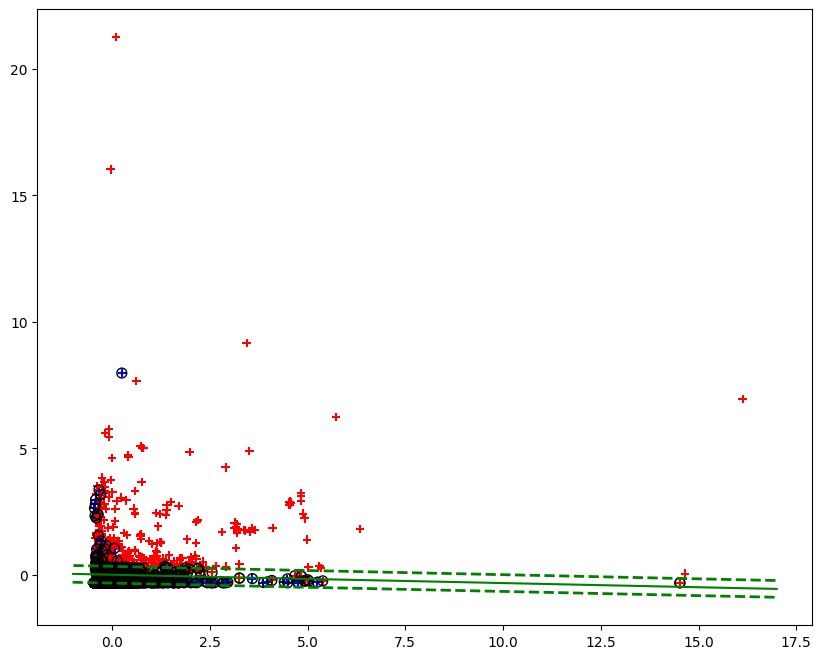

In [26]:
# Fit a linear SVM model with C = 1
model_svm_Q2 = svm.SVC(C = 1, kernel = 'linear')
model_svm_Q2.fit(X_data.iloc[:,0:2], X_data.y)
svm_draw(model_svm_Q2, -1, 17, X_data)

# Support vectors with C=1
print("Support Vectors :")
indexes = model_svm_Q2.support_

<font color="blue">**Todo:**</font>  
- Try different values of C (between 0.01 and 1000 for instance, by order of magnitude) and compute the training and validation scores for each value of C (use a'for' loop). 
- Select the best value of C and estimate the generalization error of the selected SVM.

In [27]:
# TODO - this can take some computing time
Cs = [0.01, 0.1, .5,  1, 2, 10, 100, 1000]
errors = []
for C in Cs:
    model_svm_Q2 = svm.SVC(C = C, kernel = 'linear')
    model_svm_Q2.fit(X_data.iloc[:,0:2], X_data.y)
    errors.append(1 - model_svm_Q2.score(X_validation.iloc[:,0:2], X_validation.y))

print(errors)    

[0.22865412445730826, 0.19971056439942114, 0.19971056439942114, 0.19826338639652674, 0.20115774240231543, 0.20115774240231543, 0.20115774240231543, 0.20115774240231543]


Text(0, 0.5, 'Generalization error')

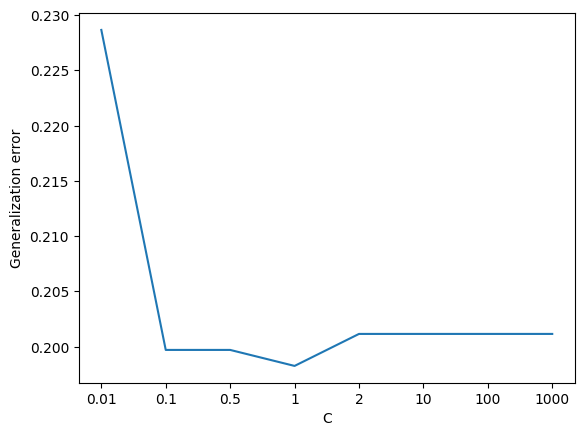

In [28]:
# TODO - estimate the generalization error of the selected SVM
Cs_string = [str(c) for c in Cs] 
plt.plot(Cs_string, errors)
plt.xlabel("C")
plt.ylabel("Generalization error")


<font color="red">**Question 3:**</font> 
- give the best C value
- compare the generalization error using this tuned value and the default value (C=1)

> Q3: The best C value is 1, because the generalisation is the lowest.
>
> We can say that the default value is a great choice for this dataset.

# <font color="#1E90FF">Exercise 3: Non-linear SVM</font>

We move here on SVM using kernel functions.

## <font color="#9400D3">1. Data analysis</font>

In [29]:
# Load a dataset
#dataset = pd.read_csv("./data/SepNonLineaire.csv")
dataset = pd.read_csv("./SepNonLineaire.csv")
dataset

,x1,x2,y
0,1.5,4.0,1
1,1.0,2.0,1
2,0.0,0.0,1
3,1.0,4.0,1
4,0.5,3.0,1
...,...,...,...
145,-2.8,-3.3,0
146,-2.8,1.0,0
147,-2.8,3.0,0
148,-2.4,3.0,0


<font color="red">**Question 1:**</font> How many examples? features? distribution of the target values ?

In [30]:
print("Numbers of example : 150")
print("Features : 1, 0")

# Distribution 
dataset.describe()
print(dataset.y.value_counts())

Numbers of example : 150
Features : 1, 0
0    105
1     45
Name: y, dtype: int64


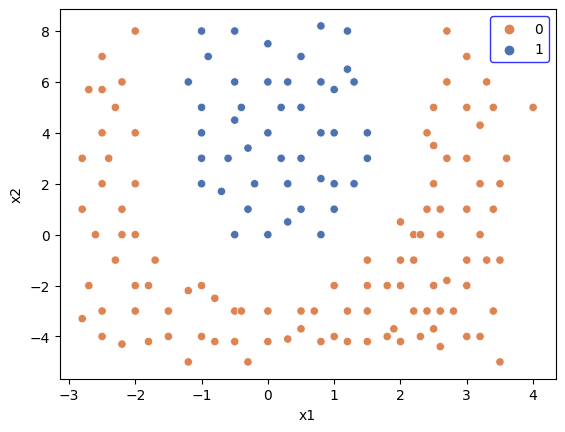

In [31]:
sns.scatterplot(data=dataset, x='x1', y='x2', hue='y', palette=sns.color_palette("deep")[0:2][::-1])
legend = plt.legend(frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('b')

<font color="red">**Question 2:**</font> Is this dataset linearly separable ?

> Q2: Visually, it is not linearly separable. We can clearly see that there are two classes, and that the boundary between the two classes is not linear.

In [32]:
#  Split this dataset into training/validation/test
X_data, X_test = train_test_split(dataset, test_size=0.3, random_state=42)
X_test, X_validation = train_test_split(X_test, test_size=0.5, random_state=42)


## <font color="#9400D3">2. Linear SVM</font>

<font color="blue">**Todo:**</font> try a linear SVM, compute the real error, and draw the boundaries, just to see.

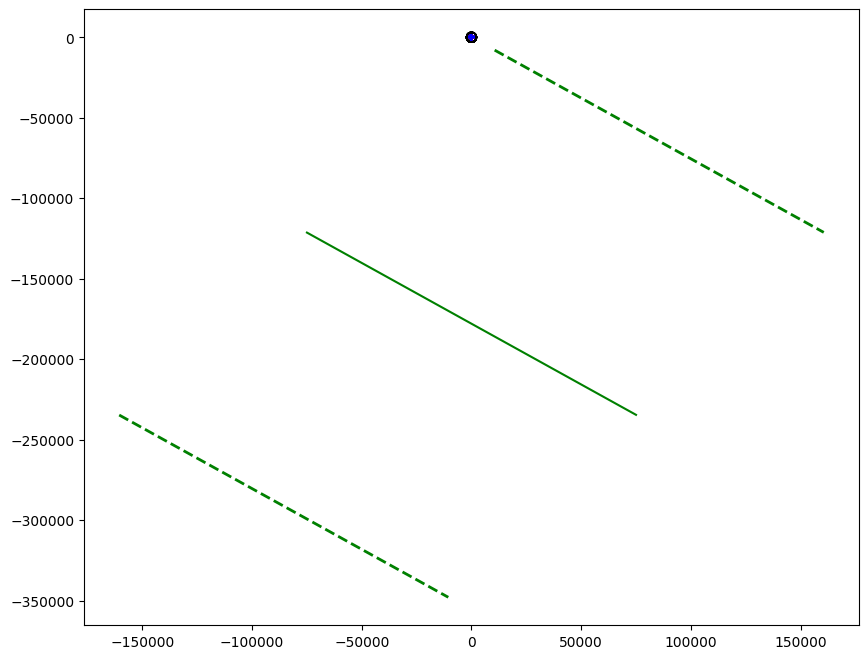

In [33]:
# linear SVM
model_svm = svm.SVC(C = 1, kernel = 'linear')
model_svm.fit(X_data.iloc[:,0:2], X_data.y)
# draw the boundaries
svm_draw(model_svm, -75000, 75000, X_data)

We can notice that the boundary is far from the data. This is because the data is not linearly separable.

## <font color="#9400D3">3. Radial SVM</font>

We will apply a radial SVM (with rbf kernel).
For this, you just need to specify <code>kernel = 'rbf'</code> rather than <code>kernel = 'linear'</code>.
And you'll also need to set a value for gamma (otherwise there is a default value)

<font color="blue">**Todo:**</font> 
 - Fit a rbf SVM with C = 1 and gamma = 10
 - Compute train and validation scores
 - Plot the decision boundaries and the margins using the function <code>draw_boundary</code> above
 
<font color="red">**Question 3:**</font> 
What phenomenon can you observe here ?

In [34]:
X_data, X_test = train_test_split(dataset, test_size=0.3, random_state=42)
X_test, X_validation = train_test_split(X_test, test_size=0.5, random_state=42)

In [35]:
# Fit a radial SVM
# Fit a rbf SVM with C = 1 and gamma = 10
model_svm_radial = svm.SVC(C = 1, gamma=10, kernel = 'rbf')
model_svm_radial.fit(X_data.iloc[:,0:2], X_data.y)

#  Compute train and validation scores

# valid_score = model_svm_radial.score(X_validation.iloc[:,0:2], X_validation.y)
#print("Validation score : ", valid_score)

SVC(C=1, gamma=10)

In [36]:
def draw_boundary(model, data, x_min, x_max, y_min, y_max):
    h = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    zz = np.c_[xx.ravel(), yy.ravel()]
    zz = pd.DataFrame(zz)
    zz2 = zz
    pred_zz= pd.Series(model.predict(zz2))
    color_map = matplotlib.colors.ListedColormap(pd.Series(['blue', 'red']))
    fig = plt.figure(figsize=  (8,8))
    fig = plt.scatter(zz.iloc[:,0], zz.iloc[:,1], c = pred_zz, cmap = color_map, marker='+')
    fig = plt.scatter(data.iloc[:,0], data.iloc[:,1], s = 50, c = data.iloc[:,2], cmap = color_map)
    

C:\Users\dounk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


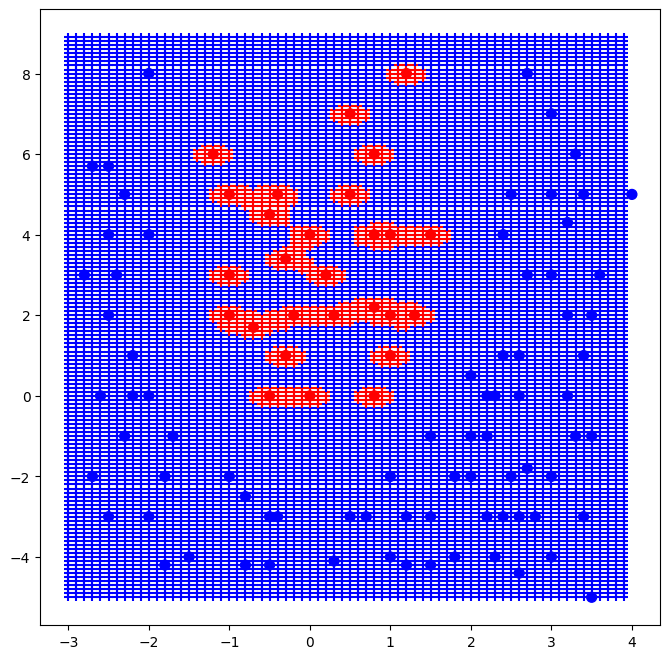

In [37]:
draw_boundary(model_svm_radial, X_data, -3, 4, -5, 9)

<font color="blue">**Todo:**</font>
- Try now to modify C and gamma to have a better decision boundary
- Choose the best values of C and gamma 
- Estimate the generalization error of this SVM
- draw the boundaries

In [38]:
# search for best C and gamma values using validation set
Cs = [0.1, 0.5, 0.8, 1, 2, 10, 100, 1000]
Gs = [1,2,4,6,8, 10, 20, 100]
errors = []
min_error = 1
best_C = 0
best_gamma = 0
best_model = None
for C in Cs :
    for gamma in Gs :
        model_svm_radial = svm.SVC(C = C, gamma=gamma, kernel = 'rbf')
        model_svm_radial.fit(X_data.iloc[:,0:2], X_data.y)

        # generalization error estimation
        score = model_svm_radial.score(X_validation.iloc[:,0:2], X_validation.y)
        err = 1 - score

        errors.append(err)
        if err < min_error or best_model == None :
            min_error = err
            best_C = C
            best_gamma = gamma
            best_model = model_svm_radial
        #print("C = ", C, "gamma = ", gamma, "Validation score : ", score)

Text(0, 0.5, 'Generalization error')

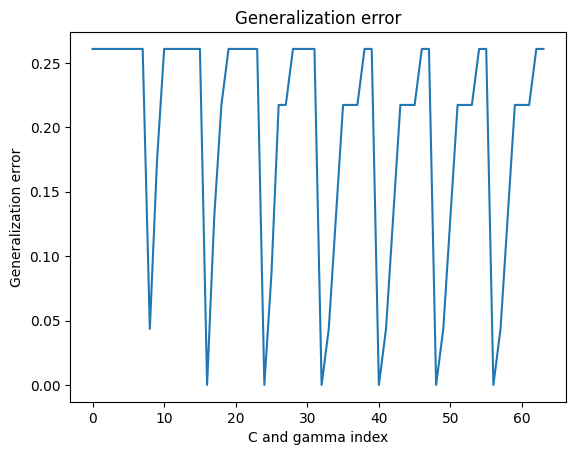

In [39]:
plt.plot(errors)
plt.title("Generalization error")
plt.xlabel("C and gamma index")
plt.ylabel("Generalization error")

In [40]:
print("Best C = ", best_C)
print("Best gamma = ", best_gamma)
print("Best error = ", min_error)

Best C =  0.8
Best gamma =  1
Best error =  0.0


C:\Users\dounk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


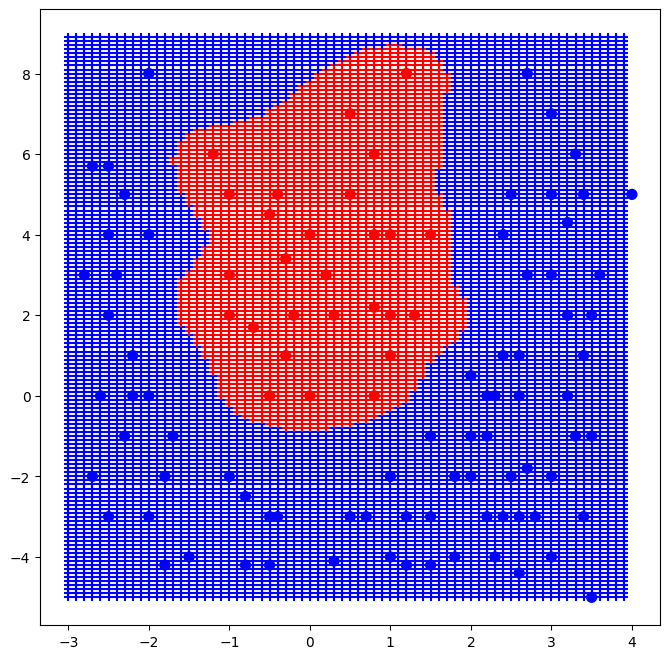

In [41]:
# draw the boundaries
draw_boundary(best_model, X_data, -3, 4, -5, 9)


<font color="blue">**Todo:**</font> You can also try polynomial kernels by specifying <code>kernel = 'poly'</code>. You'll have to tune the parameter <code>'degree'</code> with this kernel.

Note that in SVC, polynomial kernel is defined as: $$ K(x,x')=(\gamma (x.x') + r)^d$$ where $d$ is specified by parameter <code>degree</code>, r by <code>coef0</code> (default=0.0).

In [51]:
# TODO - Fit a polynomial kernel. Find the best C and degree using validation set
# Polynomial kernel with SVM, degre = 2 :

# TODO - search for best C and gamma values using validation set
deg = [1,2,4,6,8, 10, 20, 100]
errorsPoly = []
for d in deg :
        model_svm_poly = svm.SVC(kernel = 'poly', degree=d)
        model_svm_poly.fit(X_data.iloc[:,0:2], X_data.y)

        # TODO - generalization error estimation
        score = model_svm_poly.score(X_validation.iloc[:,0:2], X_validation.y)
        errorsPoly.append(1 - score)

print(errorsPoly)

0.782608695652174
[0.21739130434782605]


<font color="red">**Question 4:**</font> 
- Which are finally the best hyper-parameters?
- Evaluate the final model on the test set.

## <font color="#9400D3">4. Expert mode</font>

When tuning the hyper-parameters with a validation set, rather than using several 'for', scikit learn offers a <code>GridSearchCV(estimator, param_grid)</code> function : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

The parameters of the estimator (classifier) are optimized by **cross-validated** grid-search over a parameter grid. Candidates are exhaustively generated from a grid of parameter values specified with the <code>param_grid</code> parameter.

In [ ]:
param_grid = [
              {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4], 'kernel': ['poly']},
              {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf']},
              ]
print("\n # Tuning hyper-parameters")
clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
clf.fit(train_set.iloc[:,:2], train_set.y)


print("Best parameters set found on training set:")
print(clf.best_params_)

y_pred = clf.predict(test_set.iloc[:,:2])
print("\n SVM on test set (parameter tuning) : \t", accuracy_score(test_set.y, y_pred), "\n")

<font color="red">**Question 5:**</font> 
- Explain how many learning are done in the above procedure.
- How the (hyper)-parameter are selected?
- Does that match your previous study?